# Cuda Simulator

In [1]:
%load_ext pyinstrument
"""Setup"""


import numpy as np
import sys
#from google.colab import drive
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.art3d as art3d
import numpy as np
from matplotlib.patches import Circle, Rectangle
from mpl_toolkits.mplot3d import Axes3D
from viz import *
from optics_cuda import *

#drive.mount("/content/gdrive")
np.set_printoptions(
    edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%.3g" % x)
)
# the code in this notebook is formatted with Black https://black.vercel.app/ using 3.7, which is what this says:
print(sys.version)

CuPy version 11.0.0
3.8.10 (default, Jun 22 2022, 20:18:18) 
[GCC 9.4.0]


In [3]:
%%pyinstrument
""" Generate some photons from the LED.

For now use Lambertian, it's pretty close.
TODO: use the Cree distribution
Say the units are like 100 microns?  so like 1mm square?
TODO: calibrate the size
TODO: calibrate the output
"""

###
photon_count = np.int32(100000)
source_size = np.float32(10)
source_box = [-source_size/2, source_size/2, -source_size/2, source_size/2, 0]
###
photons = LambertianSource(source_size, source_size).make_photons(photon_count)

_     ._   __/__   _ _  _  _ _/_   Recorded: 17:50:00  Samples:  11
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.269     CPU time: 0.252
/   _/                      v4.2.0

Program: /home/joel/.local/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/joel/.local/share/jupyter/runtime/kernel-45ee93a2-9d8d-43a3-bd23-bb97155ddfa6.json

0.269 <module>  <ipython-input-3-f78928ef4253>:2
`- 0.269 make_photons  optics_cuda.py:181
   |- 0.185 uniform  cupy/random/_distributions.py:822
   |     [24 frames hidden]  cupy, <built-in>
   |        0.083 compileProgram  <built-in>:0
   `- 0.082 __call__  cupyx/jit/_interface.py:57
         [39 frames hidden]  cupyx, cupy, <built-in>, inspect, tok...
            0.080 compileProgram  <built-in>:0

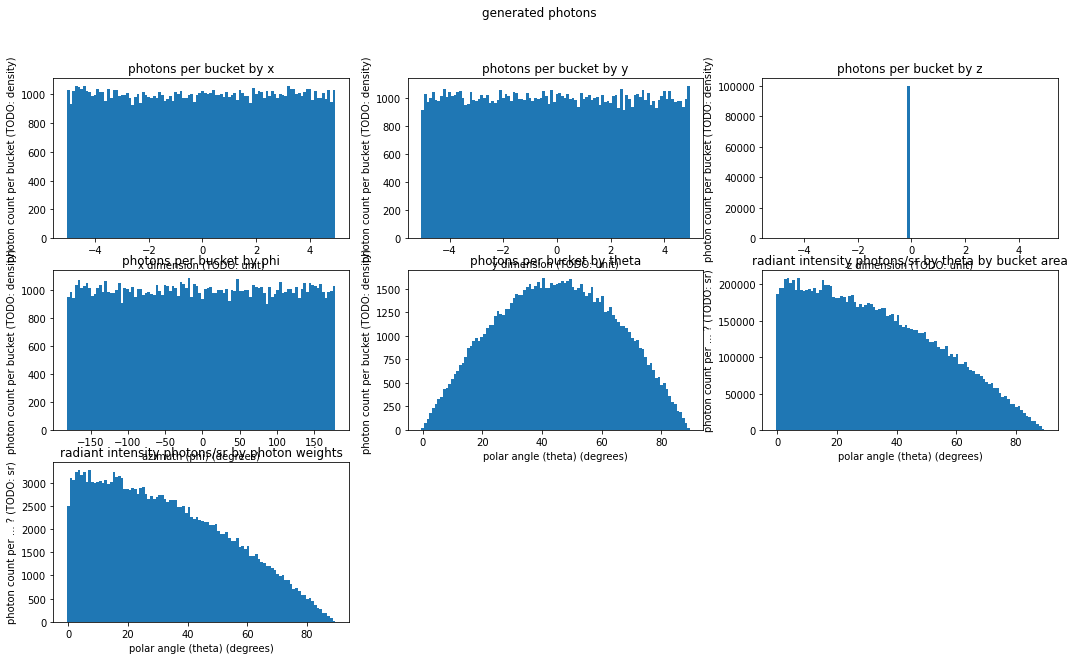

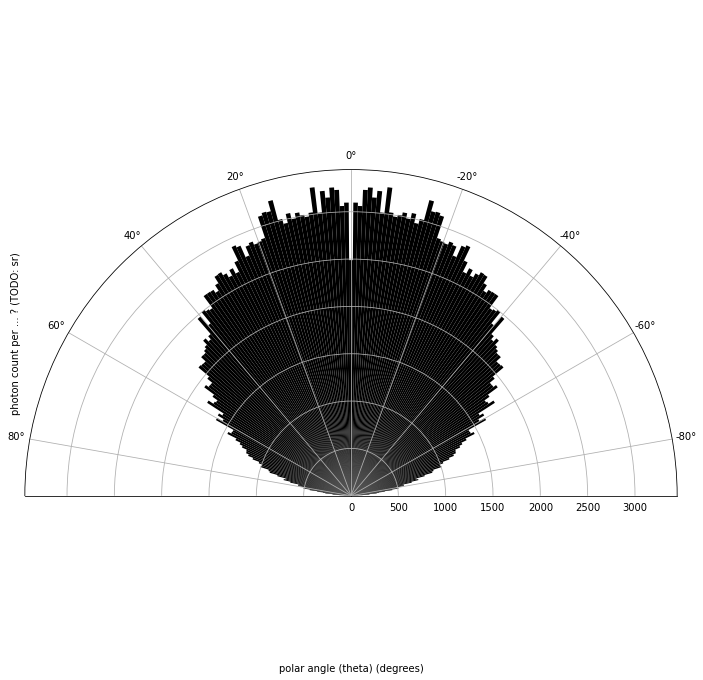

In [3]:
""" Look at the distributions of the generated photons."""
plot_histogram_slices(photons, "generated photons", -source_size/2, source_size/2, -source_size/2, source_size/2, z_min=-5, z_max=5, theta_max = np.pi/2)

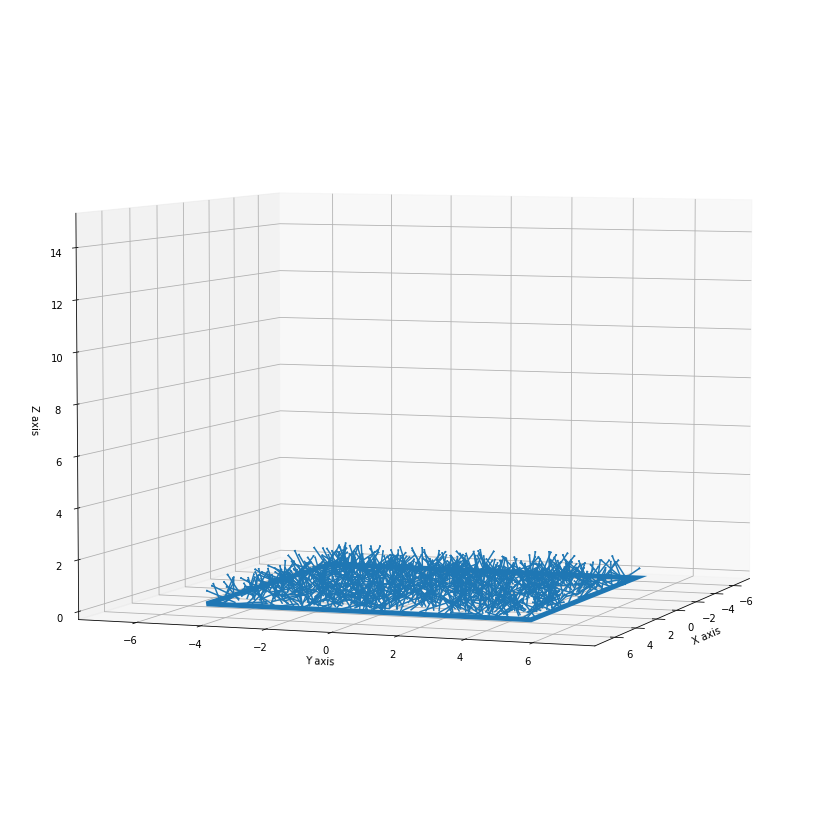

In [4]:
"""Look at the photons in 3d."""
photons_viz = Photon.sample(photons, 1000)
plot_rays([photons_viz], 5, 20, 15, 1, rectangles=[source_box])

In [5]:
%%pyinstrument
""" Propagate the photons to the diffuser.

Most arrive at the diffuser surface.
Some are absorbed by the imperfectly reflective lightbox.
A square profile (or undersquare) helps keep the intensity even at the top. 
"""
###
lightbox_height = 400
lightbox_size = 400
lightbox_box = [-lightbox_size/2, lightbox_size/2, -lightbox_size/2, lightbox_size/2, lightbox_height]
###

print(f"LED emitted photons: {Photon.countAlive(photons)}")
lightbox = Lightbox(height = lightbox_height, size = lightbox_size)
lightbox.propagate(photons)
print(f"diffuser incident photons: {Photon.countAlive(photons)}")
photons = Photon.selectAlive(photons)
print(f"alive photons: {Photon.countAlive(photons)}")

LED emitted photons: 100000
diffuser incident photons: 84416
alive photons: 84416


_     ._   __/__   _ _  _  _ _/_   Recorded: 15:23:07  Samples:  540
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.548     CPU time: 0.550
/   _/                      v4.2.0

Program: /home/joel/.local/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/joel/.local/share/jupyter/runtime/kernel-45ee93a2-9d8d-43a3-bd23-bb97155ddfa6.json

0.548 <module>  <ipython-input-5-c6304a556824>:2
|- 0.433 propagate  optics.py:283
|  |- 0.379 [self]  
|  |- 0.045 RandomState.random  <built-in>:0
|  |     [2 frames hidden]  <built-in>
|  `- 0.009 isAlive  optics.py:130
|- 0.074 countAlive  optics.py:138
|  |- 0.046 [self]  
|  `- 0.028 isAlive  optics.py:130
|- 0.032 selectAlive  optics.py:146
|  |- 0.020 [self]  
|  `- 0.010 isAlive  optics.py:130
`- 0.008 [self]

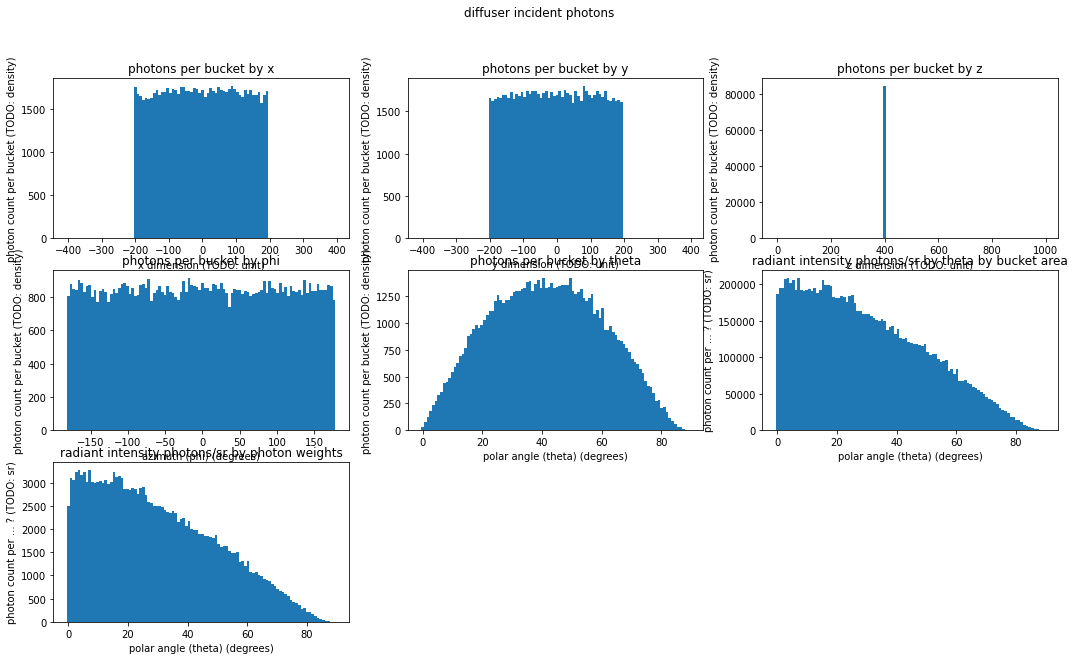

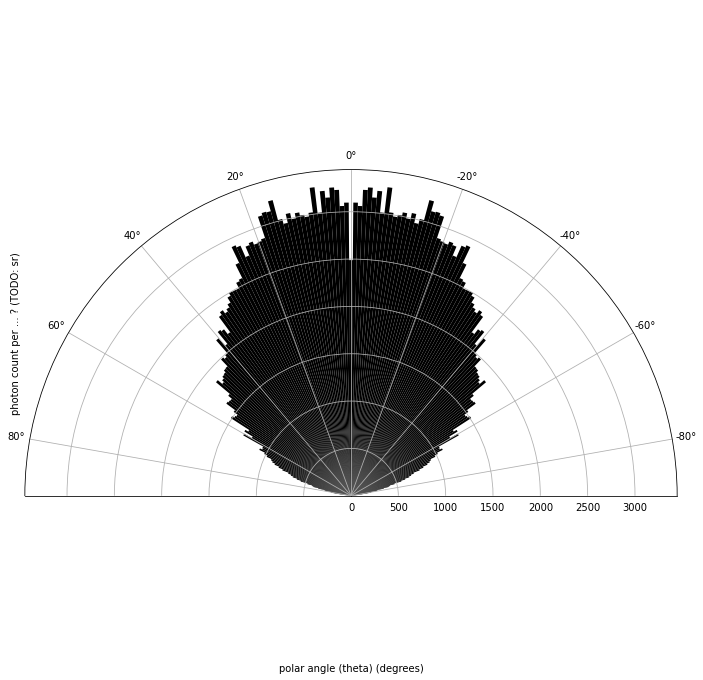

In [6]:
""" Show distributions of diffuser incident photons."""
plot_histogram_slices(photons, "diffuser incident photons", x_min=-400, x_max=400, y_min=-400, y_max=400, z_min=0, z_max=1000, theta_max = np.pi/2)

In [7]:
%%pyinstrument
""" Diffuse through the diffuser. """
print(f"diffuser-incident photons: {Photon.countAlive(photons)}")
diffuser = Diffuser(g = 0.64, absorption = 0.16)
diffuser.diffuse(photons)
print(f"diffuser-transmitted photons: {Photon.countAlive(photons)}")
photons = Photon.selectAlive(photons)
print(f"alive photons: {Photon.countAlive(photons)}")
diffused_photons_viz = Photon.sample(photons, 1000)

diffuser-incident photons: 84416
diffuser-transmitted photons: 70968
alive photons: 70968


_     ._   __/__   _ _  _  _ _/_   Recorded: 15:23:13  Samples:  1270
 /_//_/// /_\ / //_// / //_'/ //     Duration: 1.284     CPU time: 1.280
/   _/                      v4.2.0

Program: /home/joel/.local/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/joel/.local/share/jupyter/runtime/kernel-45ee93a2-9d8d-43a3-bd23-bb97155ddfa6.json

1.284 <module>  <ipython-input-7-3e05430e09df>:2
|- 1.113 diffuse  optics.py:255
|  |- 0.820 scatterBy  optics.py:125
|  |  |- 0.780 rotateAround  optics.py:46
|  |  |  |- 0.640 [self]  
|  |  |  `- 0.140 normalize  optics.py:30
|  |  `- 0.040 [self]  
|  |- 0.166 getScatteringAngles  optics.py:246
|  |  |- 0.134 [self]  
|  |  `- 0.032 RandomState.random  <built-in>:0
|  |        [2 frames hidden]  <built-in>
|  |- 0.068 [self]  
|  `- 0.050 RandomState.random  <built-in>:0
|        [2 frames hidden]  <built-in>
|- 0.069 sample  optics.py:134
|  `- 0.067 deepcopy  copy.py:128
|        [64 frames hidden]  copy, <built-in>, copyreg
|- 0.066 countAlive  optics.py:138
|  |- 0.045 [self]  
|  `- 0.021 isAlive  optics.py:130
`- 0.028 selectAlive  optics.py:146
   `- 0.019 [self]

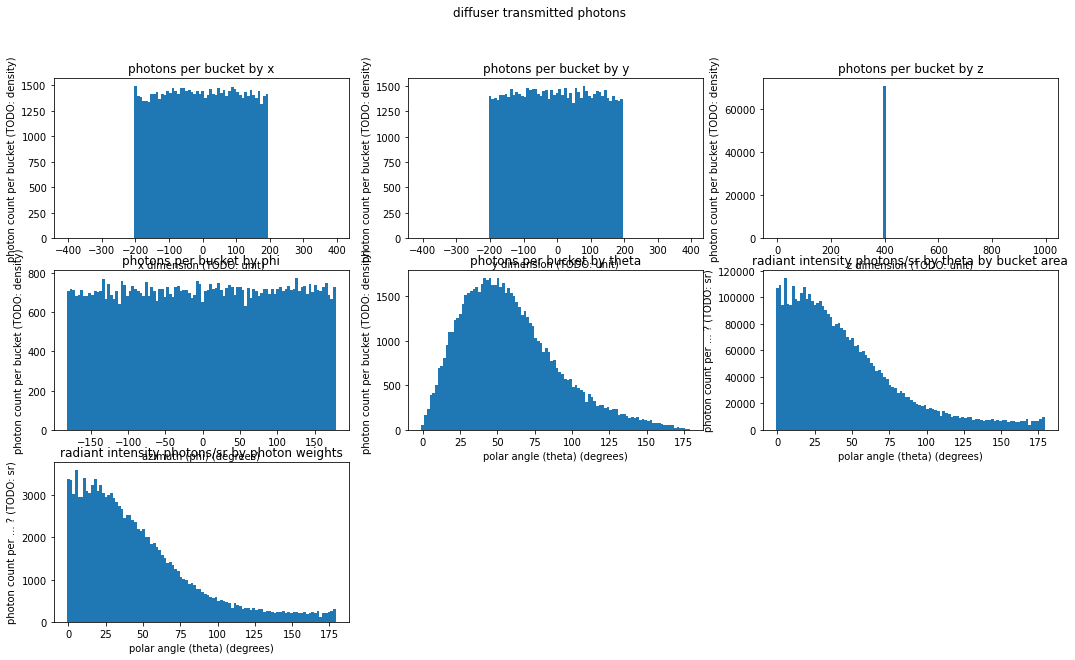

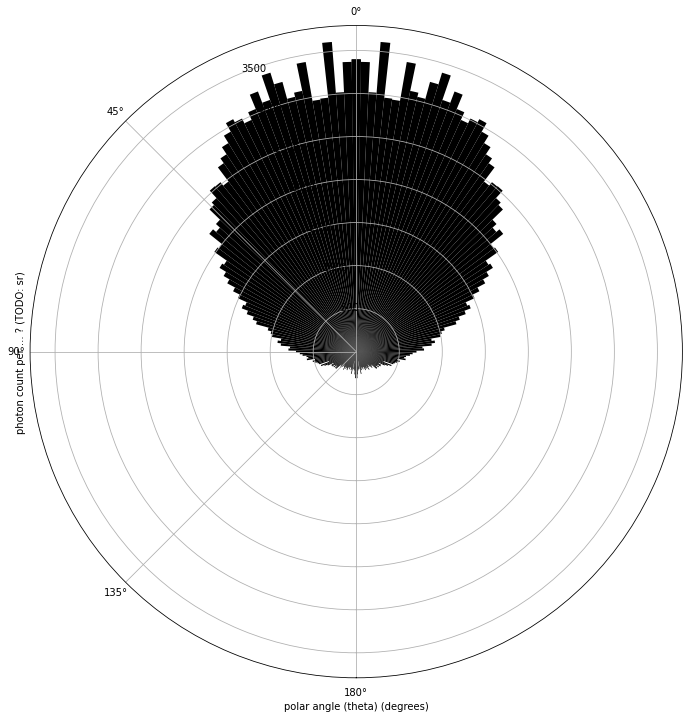

In [8]:
""" Show the distributions of photons transmitted by the diffuser.

Notice the distribution goes all the way to 180 degrees, a small fraction
of the incident photons are scattered downward.
"""
plot_histogram_slices(photons, "diffuser transmitted photons", x_min=-400, x_max=400, y_min=-400, y_max=400, z_min=0, z_max=1000)

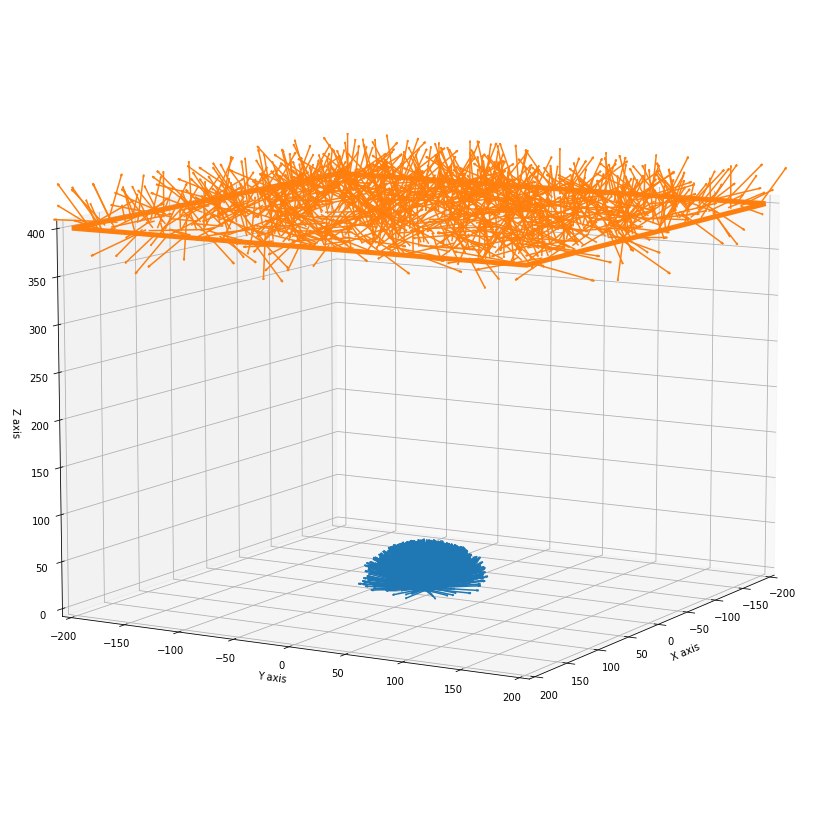

In [9]:
""" Show the LED-produced and diffuser-transmitted photons in 3d. """
plot_rays([photons_viz, diffused_photons_viz], elev = 10, azim = 30, size = max(lightbox_height, lightbox_size), arrow_length = 50,
          rectangles=[source_box, lightbox_box])

In [10]:
%%pyinstrument
""" Propagate diffuser-transmitted photons to the (far away) reflector. """
# min distance might be ... 10000 = 1 meter?  maybe less?
# max distance is probably ~100000 = 10 meters
# size might be 10cm square?
###
reflector_distance = 100000 # 1 m
reflector_box = [-500, 500, -500, 500, reflector_distance]
###
print(f"diffuser-transmitted photons: {Photon.countAlive(photons)}")
propagateToReflector(photons, location = reflector_distance, size = 1000)
print(f"reflector-incident photons: {Photon.countAlive(photons)}")
photons = Photon.selectAlive(photons)
print(f"alive photons: {Photon.countAlive(photons)}")
photons_at_reflector_viz = Photon.sample(photons, 1000)

diffuser-transmitted photons: 70968
reflector-incident photons: 1
alive photons: 1


_     ._   __/__   _ _  _  _ _/_   Recorded: 15:23:24  Samples:  145
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.168     CPU time: 0.169
/   _/                      v4.2.0

Program: /home/joel/.local/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/joel/.local/share/jupyter/runtime/kernel-45ee93a2-9d8d-43a3-bd23-bb97155ddfa6.json

0.167 <module>  <ipython-input-10-a394293ecba6>:2
|- 0.088 propagateToReflector  optics.py:336
|  |- 0.080 [self]  
|  `- 0.008 isAlive  optics.py:130
|- 0.038 countAlive  optics.py:138
|  |- 0.027 [self]  
|  `- 0.011 isAlive  optics.py:130
|- 0.023 [self]  
`- 0.018 selectAlive  optics.py:146
   |- 0.010 [self]  
   `- 0.008 isAlive  optics.py:130

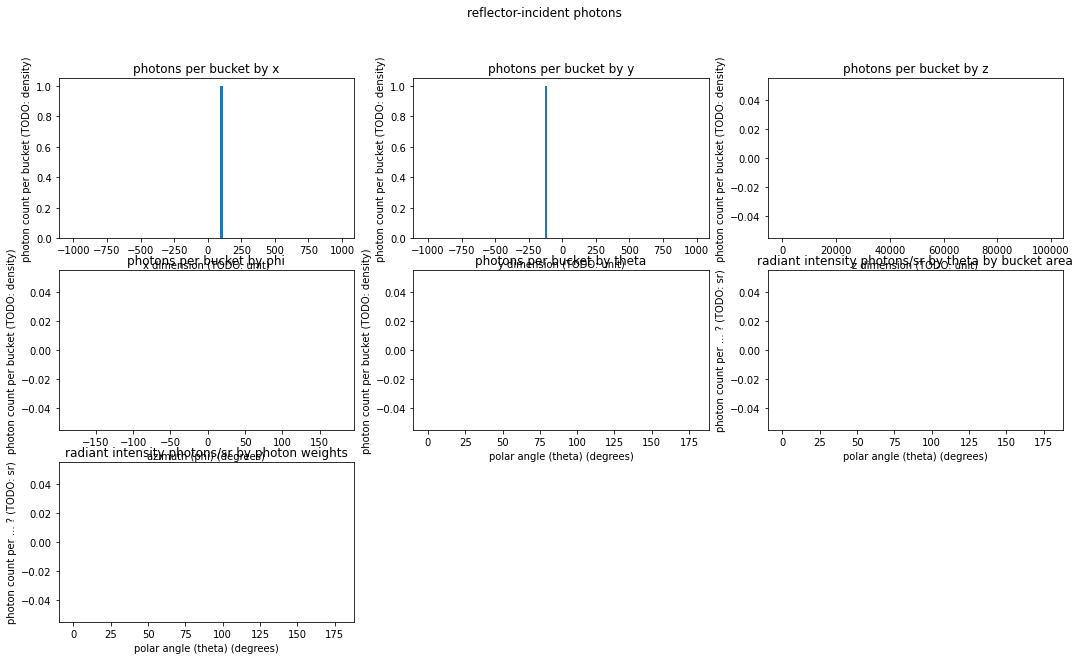

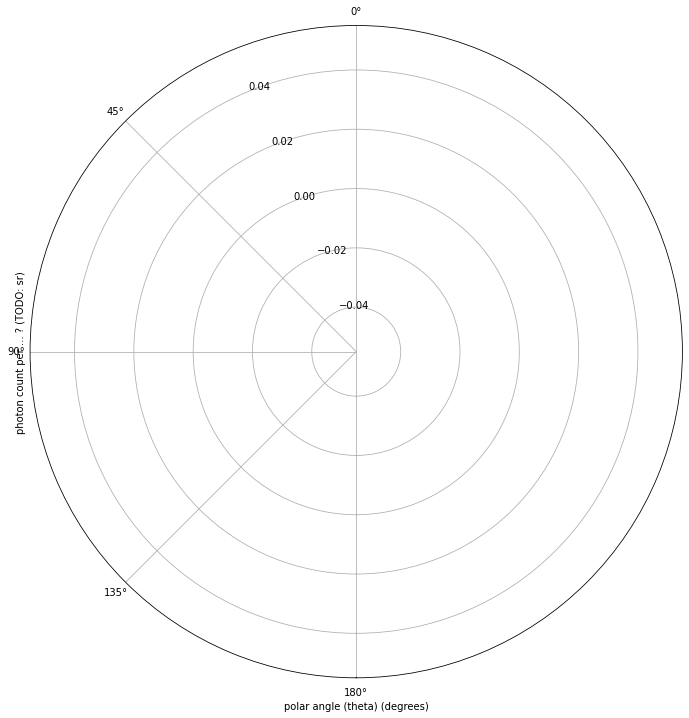

In [11]:
""" Show the distributions of reflector-incident photons """
plot_histogram_slices(photons, "reflector-incident photons", x_min=-1000, x_max=1000, y_min=-1000, y_max=1000, z_min=0, z_max=reflector_distance)

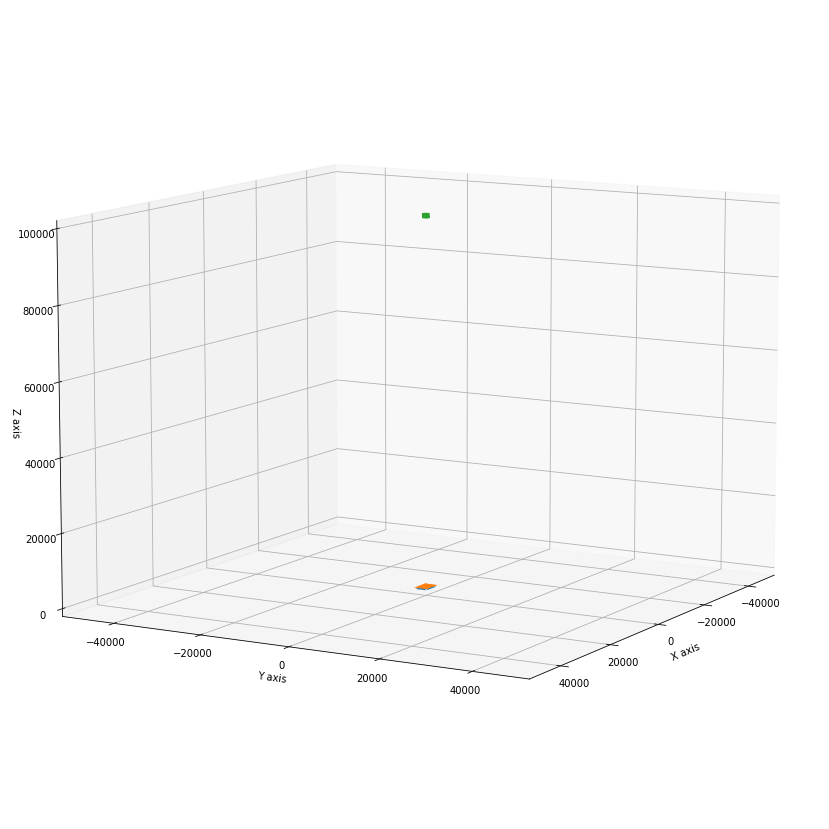

In [12]:
""" Show the generated, diffuser-transmitted, and reflector-incident photons in 3d. """
plot_rays([photons_viz, diffused_photons_viz, photons_at_reflector_viz ], 
          elev = 10, azim = 30, size = reflector_distance, arrow_length = 500,
          rectangles=[source_box, lightbox_box, reflector_box])

In [13]:
%%pyinstrument
""" Reflect the incident photons at the reflector. """
print(f"reflector-incident photons: {Photon.countAlive(photons)}")
reflector = Diffuser(g = -0.9925, absorption=0.0)
reflector.diffuse(photons)
print(f"reflected photons: {Photon.countAlive(photons)}")
photons = Photon.selectAlive(photons)
print(f"alive photons: {Photon.countAlive(photons)}")
reflected_photons_viz = Photon.sample(photons, 1000)

reflector-incident photons: 1
reflected photons: 1
alive photons: 1


_     ._   __/__   _ _  _  _ _/_   Recorded: 15:23:32  Samples:  0
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.000     CPU time: 0.001
/   _/                      v4.2.0

Program: /home/joel/.local/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/joel/.local/share/jupyter/runtime/kernel-45ee93a2-9d8d-43a3-bd23-bb97155ddfa6.json

No samples were recorded.

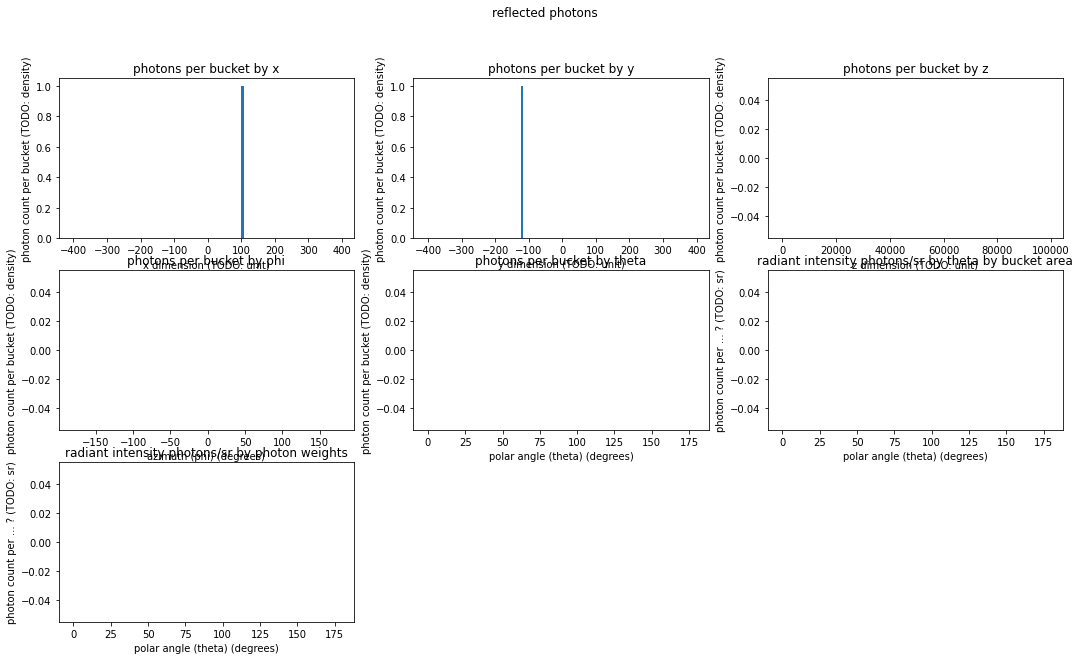

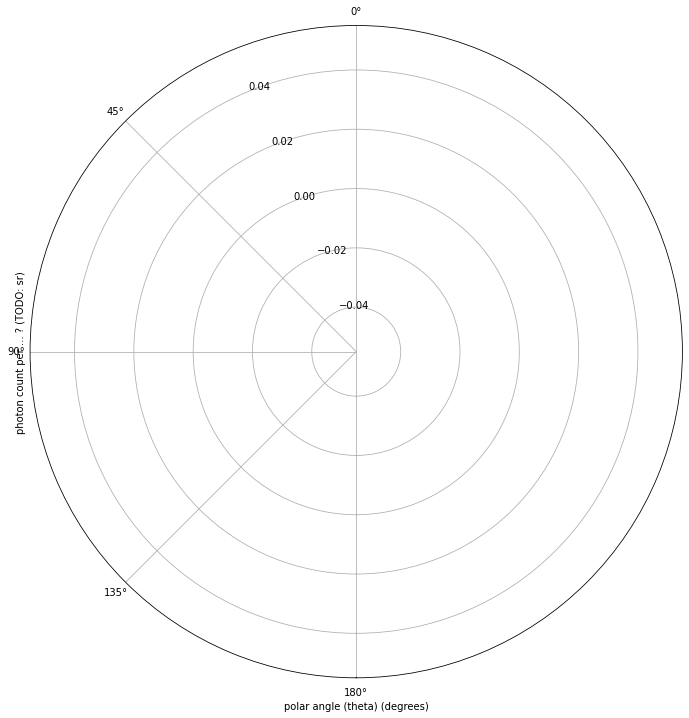

In [14]:
""" Show the distributions of reflected photons """
plot_histogram_slices(photons, "reflected photons", x_min=-400, x_max=400, y_min=-400, y_max=400, z_min=0, z_max=reflector_distance)

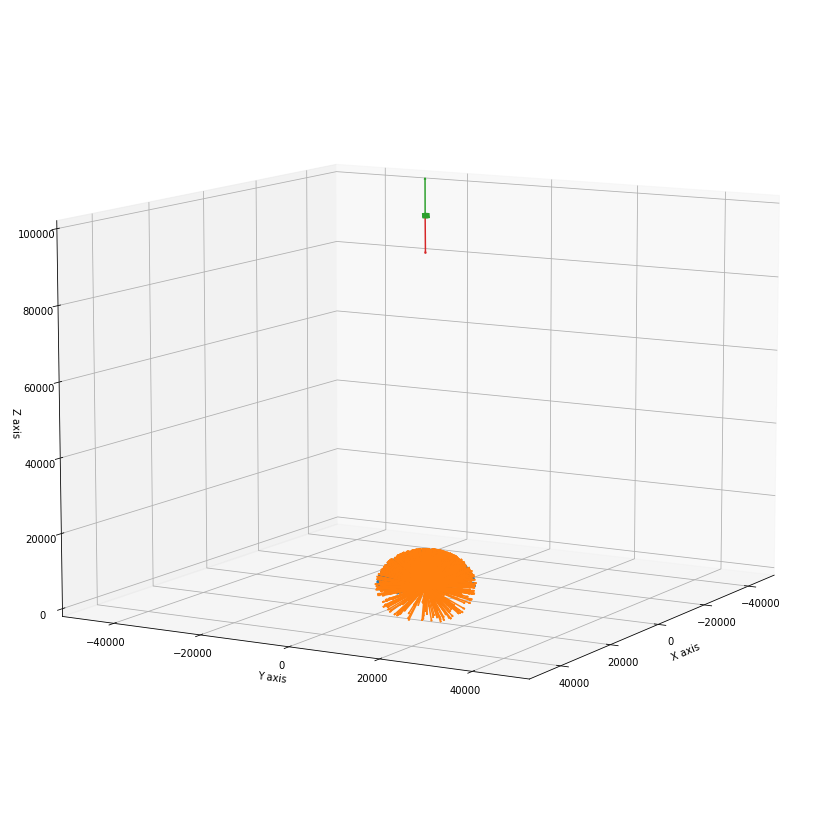

In [15]:
""" Show the generated, transmitted, reflector-incident and reflected photons in 3d. """
plot_rays([photons_viz, diffused_photons_viz, photons_at_reflector_viz, reflected_photons_viz], 
          elev = 10, azim = 30, size = reflector_distance, arrow_length = 10000,
          rectangles=[source_box, lightbox_box, reflector_box])

In [16]:
""" Propagate the reflected photons to the camera plane. """
print(f"reflected photons: {Photon.countAlive(photons)}")
propagateToCamera(photons, location = lightbox_size) # make the camera height even with the diffuser
print(f"camera-incident photons: {Photon.countAlive(photons)}")
photons = Photon.selectAlive(photons)
print(f"alive photons: {Photon.countAlive(photons)}")
photons_at_camera_plane_viz = Photon.sample(photons, 1000)

reflected photons: 1
camera-incident photons: 1
alive photons: 1


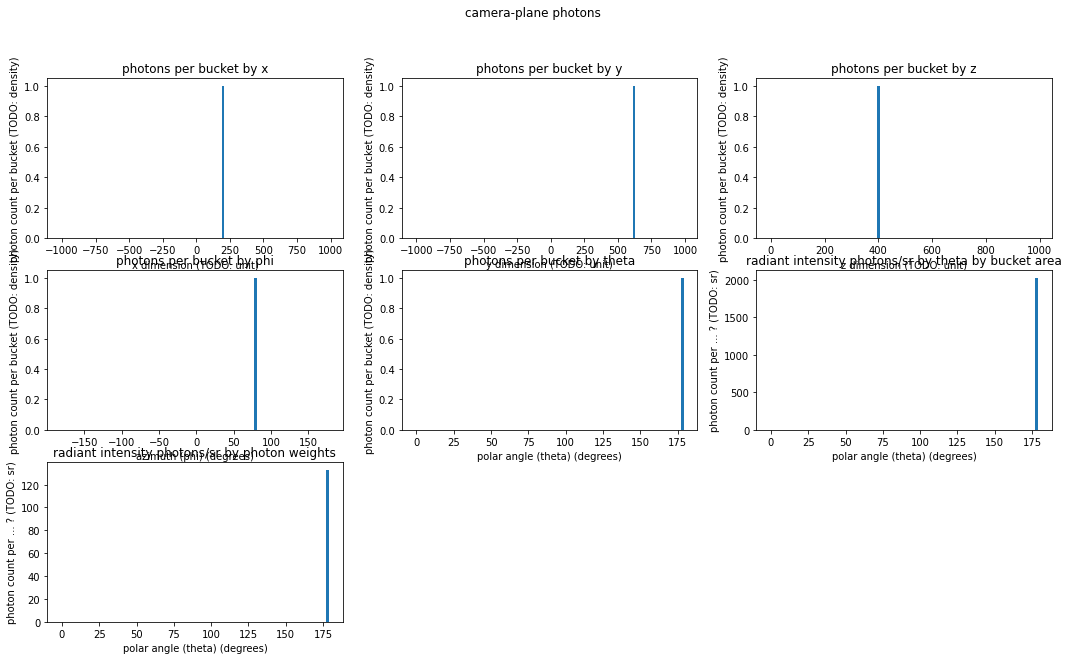

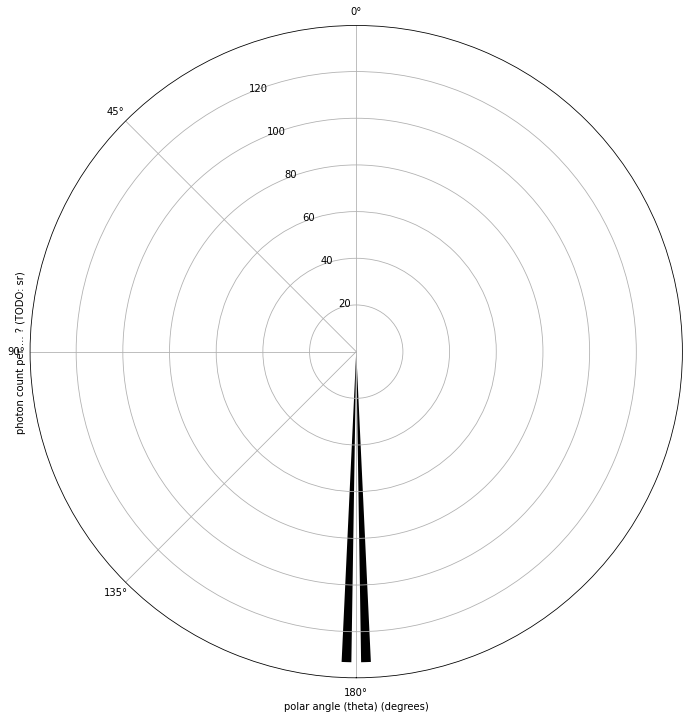

In [17]:
""" Show the distributions of camera-plane photons """
plot_histogram_slices(photons, "camera-plane photons", x_min=-1000, x_max=1000, y_min=-1000, y_max=1000, z_min=0, z_max=1000)

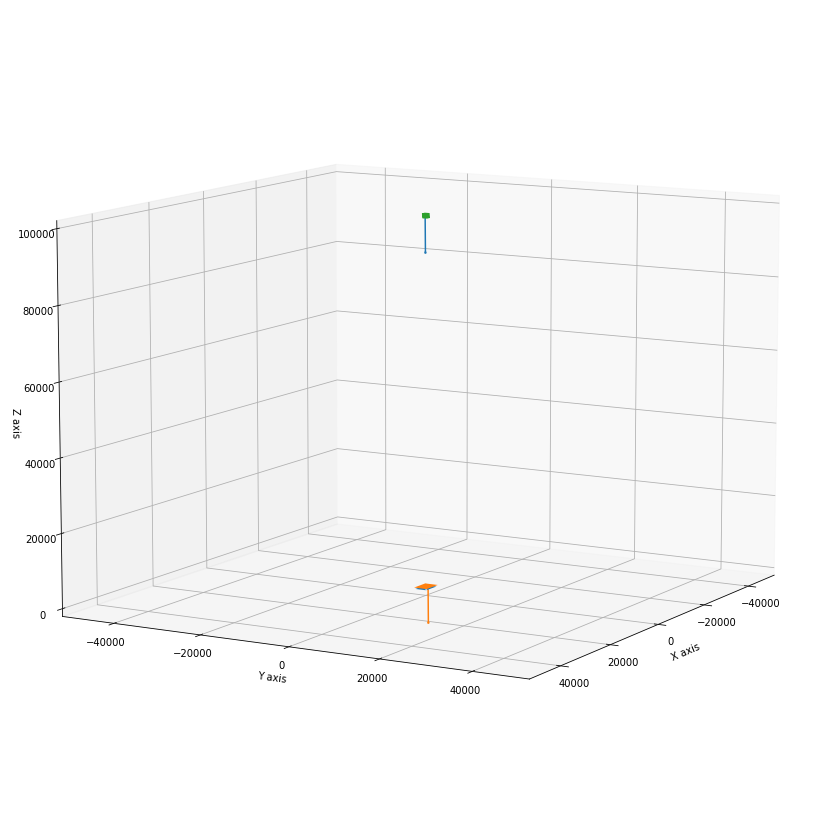

In [18]:
""" Show the reflected photons in 3d."""
plot_rays([reflected_photons_viz, photons_at_camera_plane_viz], 
          elev = 10, azim = 30, size = reflector_distance, arrow_length = 10000,
          rectangles=[source_box, lightbox_box, reflector_box])

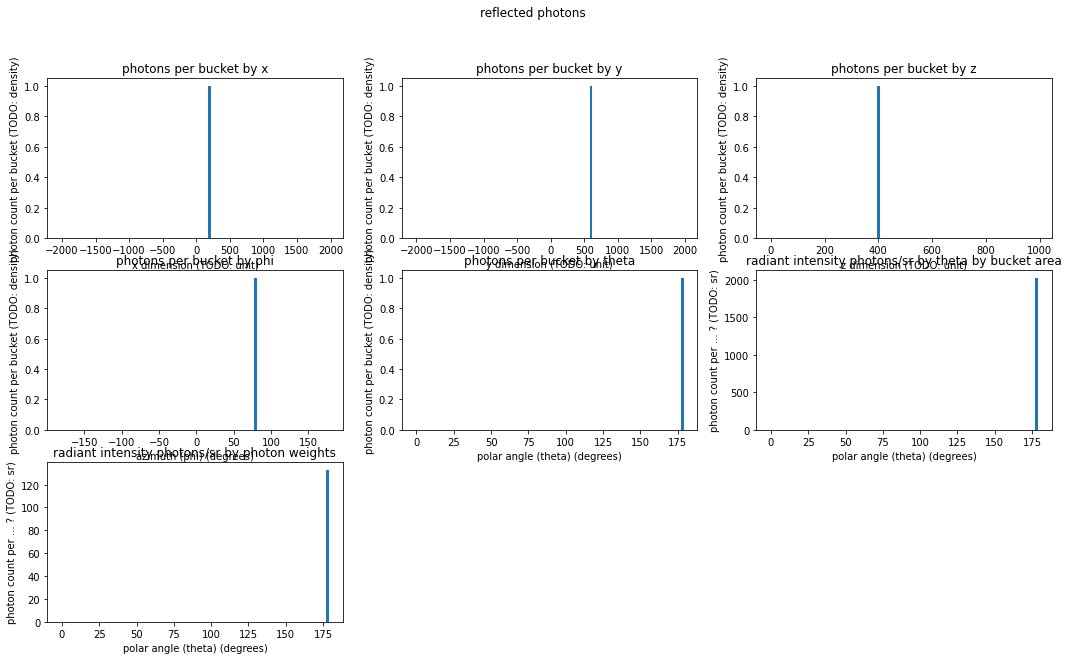

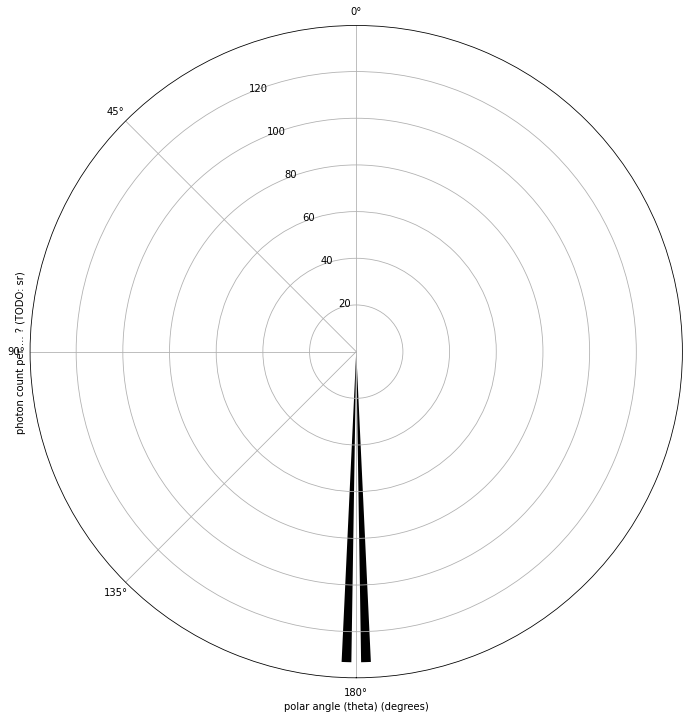

In [19]:
""" Show the distributions of reflected photons, close up """
plot_histogram_slices(photons, "reflected photons", x_min=-2000, x_max=2000, y_min=-2000, y_max=2000, z_min=0, z_max=1000)

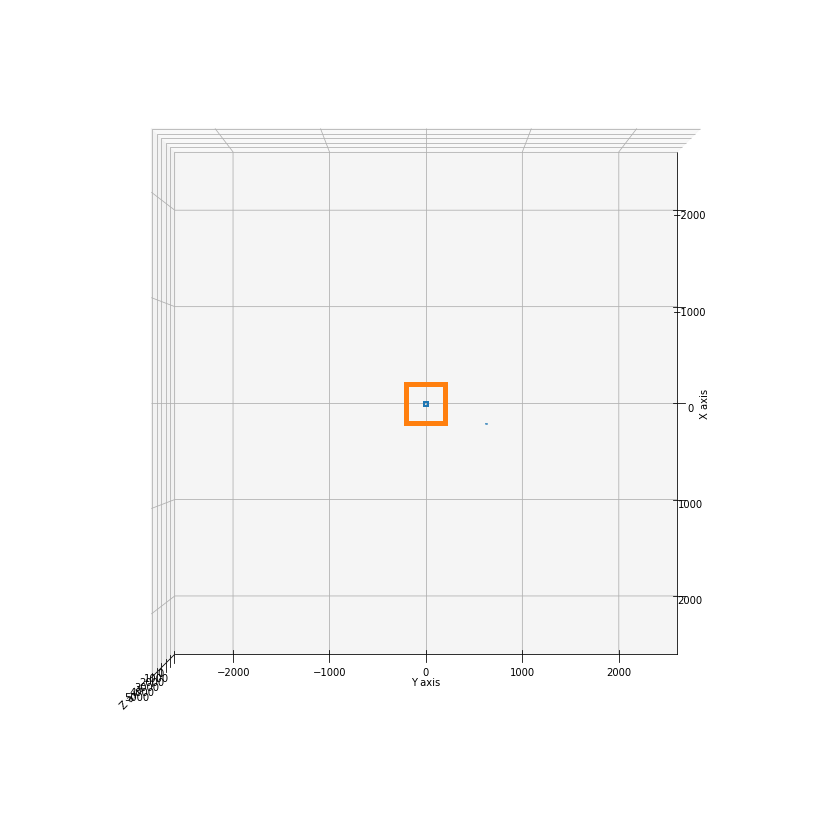

In [20]:
""" Look closer at the neighborhood of the detector. """
plot_rays([photons_at_camera_plane_viz], 
          elev = 90, azim = 0, size = 5000, arrow_length = 1000,
          rectangles=[source_box, lightbox_box])